In [6]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as la

In [7]:
D=1
dt=1e-2
T = 10
ntime = int(T/dt)
E = 1

def stepx_ensemble(X):

    x = X[0]
    y = X[1]
    z = X[2]
    n=len(x)

    xn = (x + dt*(-16*(x-y)) + np.sqrt(dt) * D * np.random.randn(n))
    yn = (y + dt*( -x*z + 45.92*x - y)  + np.sqrt(dt) * D * np.random.randn(n))
    zn = (z + dt*( x*y - 4*z)  + np.sqrt(dt) * D * np.random.randn(n))

    return np.vstack([xn,yn,zn])

Xe = np.zeros([3,1,ntime])    
for i in range(1,ntime):
    Xe[:,:,i]=stepx_ensemble(Xe[:,:,i-1])


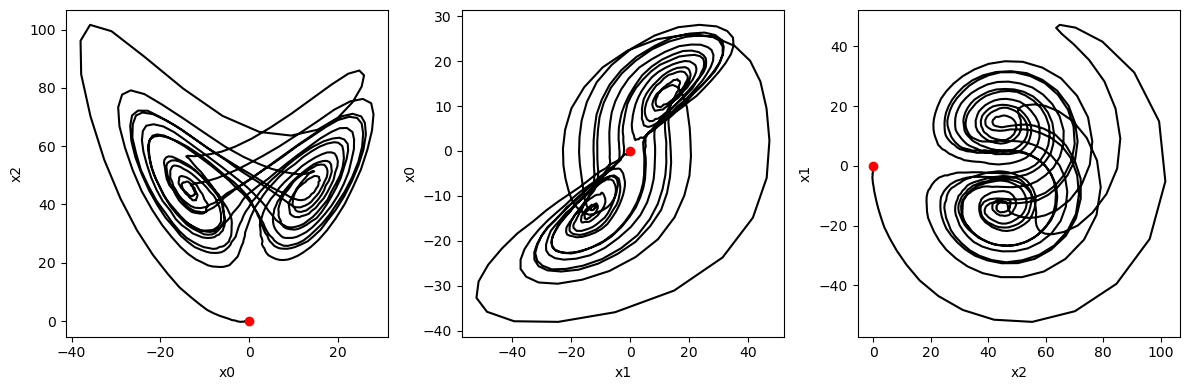

In [8]:
#make a quick plit to show the chaotic attractor 
d0l=np.arange(0,3)
d1l=np.roll(d0l,1)
fig,axs=plt.subplots(1,3,figsize=(12,4))
for i,d0,d1 in zip(range(0,3),d0l,d1l):
    axs[i].plot(Xe[d0,0,:],Xe[d1,0,:],'k-',alpha=1)
    axs[i].plot(Xe[d0,0,0],Xe[d1,0,0],'ro')
    axs[i].set_xlabel(f'x{d0}')
    axs[i].set_ylabel(f'x{d1}')
fig.tight_layout()

In [9]:
Xtrue=Xe[:,0,:]

Hobs=np.eye(3)
#Hobs=np.array([[1,0,0]])
#Hobs=np.array([[1,0,0],[0,0,1]])
nobs = np.shape(Hobs)[0]

# the noise that we are adding to the "truth"
R=0.5*np.eye(nobs)
gammaR = np.dot(R.T,R)

Zobs = np.dot(Hobs,Xtrue) + np.dot(R,np.random.randn(nobs,ntime))

# number of ensemble members 
E=50

# set up ensemble containers and initialize them 
Xfilter = np.zeros([3,E,ntime])
Xfilter[:,:,0] = Xtrue[:,0][:,np.newaxis] + 1*np.random.randn(3,E)
Pfilter = np.zeros([3,3,ntime])
Pfilter[:,:,0] = np.diag(np.ones(3))

ns = 1

#sampling rate 
tsamp = 1
nsample = int(tsamp/dt)

for i in range(1,ntime):

    # stochastically update the forecast 
    Xforecast = stepx_ensemble(Xfilter[:,:,i-1])

    Xanom = Xforecast-Xforecast.mean(axis=1)[:,np.newaxis]

    # get the forecast covariance
    Pforecast = np.dot(Xanom,Xanom.T)

    if ns == nsample-1:
        
        print(f'Analysis: {i}')

        # part of the kalman gain that we will have to invert
        S = np.dot( np.dot(Hobs, Pforecast), Hobs.T) + gammaR
        # kalman gain matrix     
        K = np.dot( Pforecast, np.dot( Hobs.T, la.inv(S) ) )

        for j in range(0,E):
            # obs innovation
            y = Zobs[:,i]+np.dot(R,np.random.randn(nobs))- np.dot(Hobs,Xforecast[:,j])
            print(i,j,np.sum(np.abs(np.dot(K,y))))
            Xfilter[:,j,i] = Xforecast[:,j] + np.dot(K,y)

        Xanom = Xfilter[:,:,i]-Xfilter[:,:,i].mean(axis=1)[:,np.newaxis]
        #analysis covariance
        Pfilter[:,:,i] = np.dot(Xanom,Xanom.T)

        ns = 0
        
    else:
        
        Xfilter[:,:,i] = Xforecast 
        Pfilter[:,:,i] = Pforecast
        
        ns+=1


Analysis: 99
99 0 33.27596336962416
99 1 7.535798841752543
99 2 22.887218347036594
99 3 24.407417528358565
99 4 88.92014393280373
99 5 15.870714329561583
99 6 64.69538180079103
99 7 76.97430473320497
99 8 81.2046219553544
99 9 41.5708769768585
99 10 38.001190713350695
99 11 14.411546816527101
99 12 79.04642990518613
99 13 89.25235198660025
99 14 7.09525871475349
99 15 98.26016802491894
99 16 83.72071597070097
99 17 9.931251831956988
99 18 78.18167469696829
99 19 95.57740319883371
99 20 74.59687981670965
99 21 19.322332934582708
99 22 61.5042931732186
99 23 44.803930728739815
99 24 6.508599308543367
99 25 77.06233281855056
99 26 95.29982862046924
99 27 74.25134515856548
99 28 30.84879320576695
99 29 86.30141623662146
99 30 33.110597258018004
99 31 62.8997883572707
99 32 26.181622671426396
99 33 36.49663159394991
99 34 15.479816091172195
99 35 29.7039433894374
99 36 69.4104716463577
99 37 90.03409374223732
99 38 105.70258432305869
99 39 30.525361888135187
99 40 37.7796664769044
99 41 78.

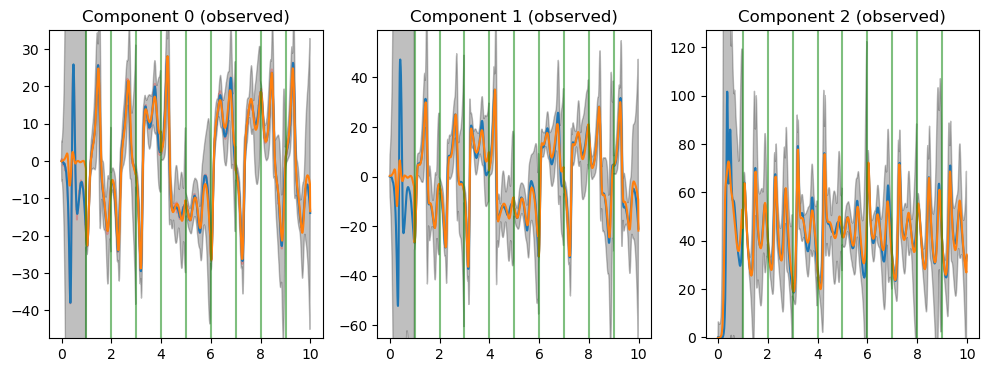

In [10]:
# make some plots and see how well the filter worked!
# I've tried to pick some parameters in this example so the filter is working, but not that well. 
# try changing the sampling frequency and the noise strength to see what values work and which don't.
# you should be able to make some guesses about nsample and R based on some of the model parameters 

# use the variances in the covariance matrix to estimate some error bounds
est_err=np.sqrt(np.vstack([Pfilter[0,0],Pfilter[1,1],Pfilter[2,2]]))
xrangep=Xfilter.mean(axis=1)+est_err
xrangem=Xfilter.mean(axis=1)-est_err

t=np.arange(0,T,dt)

plt.figure(0,figsize=(12,4))
titles=['Component 0 (observed)','Component 1 (observed)','Component 2 (observed)']
for k in range(0,3):
    plt.subplot(1,3,k+1)
    plt.fill_between(t,xrangem[k],xrangep[k],alpha=0.25,color='k')
    if k==0:
        plt.plot(t,Zobs[0],color='r',alpha=0.25)
    plt.plot(t,Xtrue[k])
    plt.plot(t,Xfilter[k].mean(axis=0))
    for i in range(1,int(T/tsamp)):
        plt.axvline(i*tsamp,color='green',alpha=0.5)
    plt.title(titles[k])
    plt.ylim([np.min(Xtrue[k])*1.25,np.max(Xtrue[k])*1.25])
